In [2]:
#Import the required libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Load the dataset into a Pandas DataFrame
df = pd.read_csv('Dataset_Uber Traffic.csv')

In [5]:
#Display the first few rows of the dataset
print(df.head())

        DateTime  Junction  Vehicles           ID
0  01/11/15 0:00         1        15  20151101001
1  01/11/15 1:00         1        13  20151101011
2  01/11/15 2:00         1        10  20151101021
3  01/11/15 3:00         1         7  20151101031
4  01/11/15 4:00         1         9  20151101041


In [6]:
#Summary statistics
print(df.describe())

           Junction      Vehicles            ID
count  48120.000000  48120.000000  4.812000e+04
mean       2.180549     22.791334  2.016330e+10
std        0.966955     20.750063  5.944854e+06
min        1.000000      1.000000  2.015110e+10
25%        1.000000      9.000000  2.016042e+10
50%        2.000000     15.000000  2.016093e+10
75%        3.000000     29.000000  2.017023e+10
max        4.000000    180.000000  2.017063e+10


In [7]:
#Information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None


In [8]:
#Check for missing values
print(df.isnull().sum())

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64


In [9]:
#Since there are no missing values, we proceed with cleaning the dataset.
#Identify duplicates
print(df.duplicated().sum())

0


In [4]:
#Convert 'Junction' and 'ID' columns to categorical data types
df['Junction'] = df['Junction'].astype('category')
df['ID'] = df['ID'].astype('category')

#Display updated data types
print(df.dtypes)

DateTime      object
Junction    category
Vehicles       int64
ID          category
dtype: object


In [11]:
#To aggregate traffic data-
#Step 1: Parse DateTime column
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [12]:
#Step 2: Set DateTime as index
df.set_index('DateTime', inplace=True)

In [13]:
#Step 3: Group by Junction and resample the data to hourly intervals, aggregating the relevant data 
#(vehicle counts, speeds, and congestion levels)
hourly_traffic = df.groupby('Junction').resample('H').sum()

In [14]:
#Step 4: Reset the index to have a clean DataFrame
hourly_traffic = hourly_traffic.reset_index(drop=True)

print(hourly_traffic)

       Junction  Vehicles           ID
0             1        15  20151101001
1             1        13  20151101011
2             1        10  20151101021
3             1         7  20151101031
4             1         9  20151101041
...         ...       ...          ...
84547         4        10  20170612194
84548         4         7  20170612204
84549         4         8  20170612214
84550         4        11  20170612224
84551         4        11  20170612234

[84552 rows x 3 columns]


In [15]:
#Extract the numerical columns to be normalized or standardized
numerical_columns = ['Junction', 'Vehicles', 'ID']

#Normalize the data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df[numerical_columns])
df_normalized = pd.DataFrame(normalized_data, columns=numerical_columns)
print(df_normalized.head())

   Junction  Vehicles            ID
0       0.0  0.078212  0.000000e+00
1       0.0  0.067039  5.120530e-07
2       0.0  0.050279  1.024106e-06
3       0.0  0.033520  1.536159e-06
4       0.0  0.044693  2.048212e-06


In [16]:
#Creating new features from raw data
#Step 1: Time-Based Features
df['DateTime'] = df.index

#Now, let's proceed with extracting time-based features
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
df['Month'] = df['DateTime'].dt.month

In [17]:
#Step 2: Lag Features (Example: Previous Hour Traffic Data)
df['PreviousHourVehicles'] = df['Vehicles'].shift(1)

In [18]:
#Step 3: Binary Indicators
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)  # 1 for weekends, 0 for weekdays
print(df.head())

                     Junction  Vehicles           ID            DateTime  \
DateTime                                                                   
2015-01-11 00:00:00         1        15  20151101001 2015-01-11 00:00:00   
2015-01-11 01:00:00         1        13  20151101011 2015-01-11 01:00:00   
2015-01-11 02:00:00         1        10  20151101021 2015-01-11 02:00:00   
2015-01-11 03:00:00         1         7  20151101031 2015-01-11 03:00:00   
2015-01-11 04:00:00         1         9  20151101041 2015-01-11 04:00:00   

                     Hour  DayOfWeek  Month  PreviousHourVehicles  IsWeekend  
DateTime                                                                      
2015-01-11 00:00:00     0          6      1                   NaN          1  
2015-01-11 01:00:00     1          6      1                  15.0          1  
2015-01-11 02:00:00     2          6      1                  13.0          1  
2015-01-11 03:00:00     3          6      1                  10.0       

C:\Users\HP\AppData\Local\Temp\ipykernel_16692\1651157843.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


Correlation with Target (Vehicles):
 Vehicles                1.000000
PreviousHourVehicles    0.969982
Junction                0.613787
ID                      0.227974
Hour                    0.219938
IsWeekend               0.096628
DayOfWeek               0.084059
Month                   0.016758
Name: Vehicles, dtype: float64


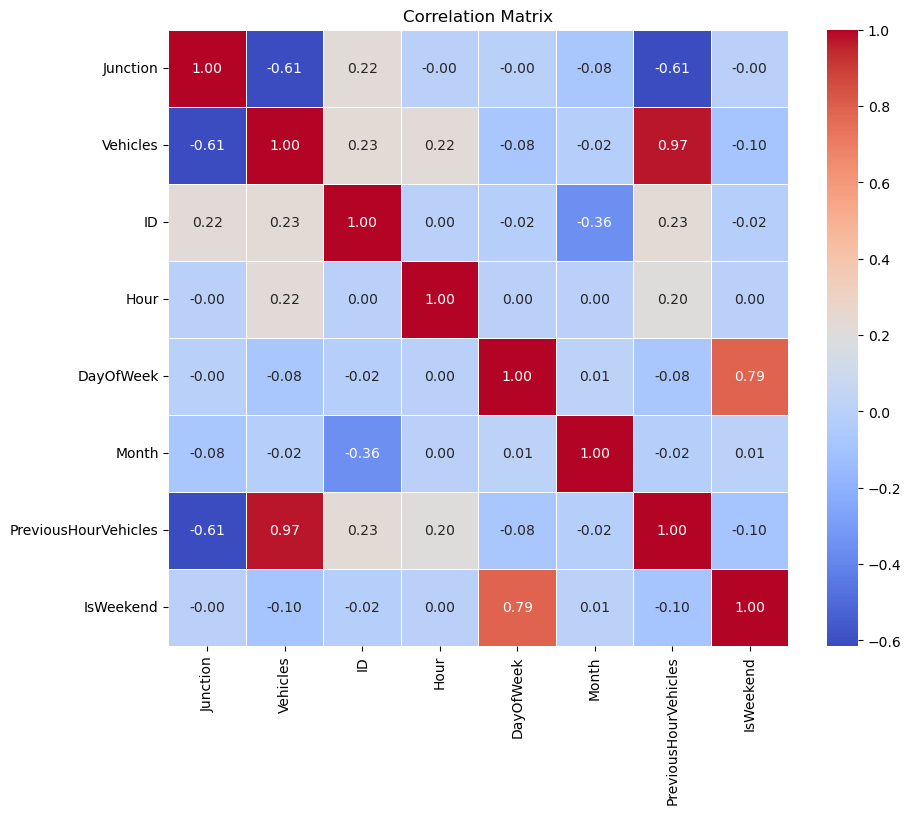

In [19]:
#Evaluating feature importance
#Step 1: Correlation Analysis
correlation_matrix = df.corr()
target_correlation = correlation_matrix['Vehicles'].abs().sort_values(ascending=False)
print("Correlation with Target (Vehicles):\n", target_correlation)

#Create heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [20]:
#Step 2: Feature Importance from Random Forest
X = df.drop(['Vehicles', 'DateTime', 'ID'], axis=1)  
X['Hour'] = df['DateTime'].dt.hour  
y = df['Vehicles']

#Impute missing values in X
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

#Train RandomForestRegressor on the imputed data
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_imputed, y)

#Extract feature importance scores
feature_importance_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importance from Random Forest:\n", feature_importance_rf)


Feature Importance from Random Forest:
 PreviousHourVehicles    0.948470
Hour                    0.024696
Month                   0.011182
DayOfWeek               0.008013
Junction                0.006610
IsWeekend               0.001029
dtype: float64


In [21]:
# Step 3: Recursive Feature Elimination (RFE)
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=5)
rfe.fit(X_imputed, y)  
selected_features_rfe = X.columns[rfe.support_]
print("\nSelected Features using RFE:\n", selected_features_rfe)


Selected Features using RFE:
 Index(['Junction', 'Hour', 'DayOfWeek', 'Month', 'PreviousHourVehicles'], dtype='object')


In [22]:
# Step 4: SelectKBest
skb = SelectKBest(score_func=f_regression, k=5)
X_new = skb.fit_transform(X_imputed, y) 
selected_features_skb = X.columns[skb.get_support()]
print("\nSelected Features using SelectKBest:\n", selected_features_skb)


Selected Features using SelectKBest:
 Index(['Junction', 'Hour', 'DayOfWeek', 'PreviousHourVehicles', 'IsWeekend'], dtype='object')


In [25]:
# Ensure 'DateTime' column is in datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Extract date from 'DateTime' for merging
df['Date'] = df['DateTime'].dt.date

# Load weather and event data
df2 = pd.read_csv('WeatherEvent_data.csv', encoding='latin1')

# Ensure 'Date' column is in datetime format
df2['Date'] = pd.to_datetime(df2['Date'], format='%d/%m/%Y').dt.date

# Verify the date range and distribution in both datasets
print(f"Traffic data date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Weather/event data date range: {df2['Date'].min()} to {df2['Date'].max()}")

# Display first few rows of each dataset to inspect
print(df.head())
print(df2.head())

# Merge traffic data with event/weather data on the 'Date' column
merged_df = pd.merge(df, df2, on='Date', how='left')

# Check for missing values in the merged DataFrame
print(merged_df.isnull().sum())

# Display the first few rows of the merged DataFrame
print(merged_df.head())

Traffic data date range: 2015-01-11 to 2017-12-06
Weather/event data date range: 2023-01-13 to 2023-12-25
                     Junction  Vehicles           ID            DateTime  \
DateTime                                                                   
2015-01-11 00:00:00         1        15  20151101001 2015-01-11 00:00:00   
2015-01-11 01:00:00         1        13  20151101011 2015-01-11 01:00:00   
2015-01-11 02:00:00         1        10  20151101021 2015-01-11 02:00:00   
2015-01-11 03:00:00         1         7  20151101031 2015-01-11 03:00:00   
2015-01-11 04:00:00         1         9  20151101041 2015-01-11 04:00:00   

                     Hour  DayOfWeek  Month  PreviousHourVehicles  IsWeekend  \
DateTime                                                                       
2015-01-11 00:00:00     0          6      1                   NaN          1   
2015-01-11 01:00:00     1          6      1                  15.0          1   
2015-01-11 02:00:00     2          6     

In [26]:
#Check for null values
print(merged_df.isnull().sum())

Junction                    0
Vehicles                    0
ID                          0
DateTime                    0
Hour                        0
DayOfWeek                   0
Month                       0
PreviousHourVehicles        1
IsWeekend                   0
Date                        0
Event                   48120
Temperature             48120
Humidity                48120
Pressure                48120
Wind Speed              48120
dtype: int64


In [30]:
merged_df.fillna(merged_df.mean(numeric_only=True), inplace=True)
merged_df.fillna('Unknown', inplace=True)

print(merged_df.isnull().sum())

Junction                0.0
Vehicles                0.0
ID                      0.0
DateTime                0.0
Hour                    0.0
DayOfWeek               0.0
Month                   0.0
PreviousHourVehicles    0.0
IsWeekend               0.0
Date                    0.0
Event                   0.0
Temperature             0.0
Humidity                0.0
Pressure                0.0
Wind Speed              0.0
dtype: float64


In [32]:
# List of columns to be standardized
columns_to_standardize = ['Vehicles', 'PreviousHourVehicles', 'Temperature', 'Humidity', 'Pressure', 'Wind Speed']

# Check for missing values in the columns to be standardized
if merged_df[columns_to_standardize].isnull().any().any():
    print("Warning: Missing values found in columns to be standardized. Filling with mean values.")
    merged_df.fillna(merged_df[columns_to_standardize].mean(), inplace=True)

# Create a StandardScaler object
scaler = StandardScaler()

# Standardize the columns if there are valid values
if not merged_df[columns_to_standardize].empty:
    merged_df[columns_to_standardize] = scaler.fit_transform(merged_df[columns_to_standardize])

# Display the first few rows of the cleaned and standardized DataFrame
print(merged_df.head())

# Check for remaining missing values
print(merged_df.isnull().sum())

Empty DataFrame
Columns: [Junction, Vehicles, ID, DateTime, Hour, DayOfWeek, Month, PreviousHourVehicles, IsWeekend, Date, Event, Temperature, Humidity, Pressure, Wind Speed]
Index: []
Junction                0.0
Vehicles                0.0
ID                      0.0
DateTime                0.0
Hour                    0.0
DayOfWeek               0.0
Month                   0.0
PreviousHourVehicles    0.0
IsWeekend               0.0
Date                    0.0
Event                   0.0
Temperature             0.0
Humidity                0.0
Pressure                0.0
Wind Speed              0.0
dtype: float64
